In [53]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
# Root directory of the project
ROOT_DIR = os.path.abspath("/lfs/jonas/maskrcnn/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [54]:
class SatsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "sats"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
    USE_MINI_MASK = False
    MINI_MASK_SHAPE = (128,128)
    
config = SatsConfig()

In [55]:
def load_image(image_path):
    """Load the specified image and return a [H,W,3] Numpy array.
    """
    from skimage.io import imread

    image = np.array(imread(image_path), dtype=float)
        
    bands = [4,2,1]
            
    image = image[:,:,bands]
        
    #image = (image * 255) / image.max()
        
    mean_std_data = np.loadtxt('image_mean_std.txt', delimiter=',')
    mean_std_data = mean_std_data[bands,:]
    image = preprocessing_image_ms(image, mean_std_data[:,0], mean_std_data[:,1])
        
    return image   
    
def load_orig_image(image_path):
    """Load the specified image (without stand.) and return a [H,W,3] Numpy array.
    """
    from skimage.io import imread
    # Load image
    image = np.array(imread(image_path), dtype=float)
        
    bands = [4,2,1]
        
    image = image[:,:,bands]
        
    image = (image * 255) / image.max()
        
    return image   
def preprocessing_image_ms(x, mean, std):
    # loop over image bands
    for idx, mean_value in enumerate(mean):
        x[..., idx] -= mean_value
        x[..., idx] /= std[idx]
    return x


In [56]:
inf_image_path = '/data/spacenet/bldg/data/test/MUL/'
inf_glob = glob(inf_image_path + '*.tif')

In [57]:
image_path = random.sample(inf_glob, 1)[0]

In [58]:
stan_image = load_image(image_path)
orig_image = load_orig_image(image_path)

In [59]:
class InferenceConfig(SatsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /lfs/jonas/maskrcnn/logs/sats20201025T0306/mask_rcnn_sats_0024.h5
Re-starting from epoch 24


In [60]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (650, 650, 3)         min:   -2.99290  max:   11.83715  float64
molded_images            shape: (1, 128, 128, 3)      min: -125.93299  max:  -92.51247  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  650.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.17817  max:    0.97964  float32


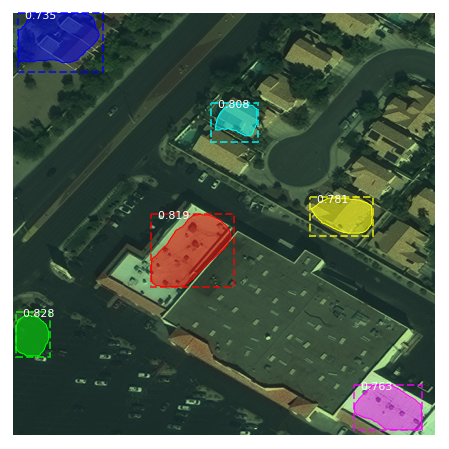

In [61]:
results = model.detect([stan_image], verbose=1)

r = results[0]

#plt.imshow(r['masks'][:,:,0])

visualize.display_instances(orig_image, r['rois'], r['masks'], r['class_ids'], 
                            'W ', r['scores'], ax=get_ax())

In [62]:
def display_local(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        #if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
        #    continue
        #y1, x1, y2, x2 = boxes[i]
        #if show_bbox:
        #    p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
        #                        alpha=0.7, linestyle="dashed",
        #                        edgecolor=color, facecolor='none')
        #    ax.add_patch(p)

        # Label
        #if not captions:
        #    class_id = class_ids[i]
        #    score = scores[i] if scores is not None else None
        #    label = class_names[class_id]
        #    caption = "{} {:.3f}".format(label, score) if score else label
        #else:
        #    caption = captions[i]
        #ax.text(x1, y1 + 8, caption,
        #        color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = visualize.find_contours(padded_mask, 0.5)
        
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = visualize.Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()


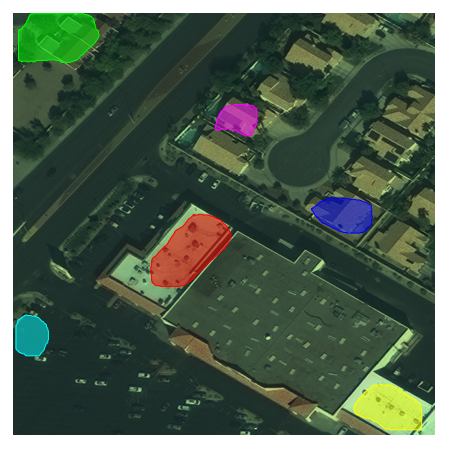

In [63]:
display_local(orig_image, r['rois'], r['masks'], r['class_ids'], 
                            'W ', r['scores'], ax=get_ax())

In [64]:
def display_centers(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    from matplotlib import patches
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        else:
            y1, x1, y2, x2 = boxes[i]
            cen_y = y1 + ((y2 - y1)/2)
            cen_x = x1 + ((x2 - x1)/2)
            p = patches.Circle((cen_x, cen_y), 5)
            ax.add_patch(p)


    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

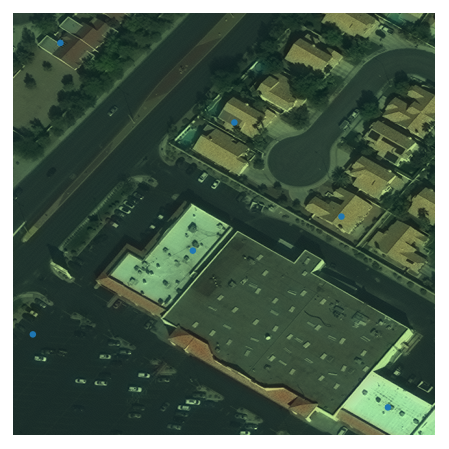

In [65]:
display_centers(orig_image, r['rois'], r['masks'], r['class_ids'], 
                            'W ', r['scores'], ax=get_ax())